# China Migration Network Hyperbolic Visualization

This notebook creates visualizations similar to Fig 1d and Fig 7 from the maritime network paper,
applied to the China internal migration network.

**Figures to create:**
1. **Fig 1d style**: Network in hyperbolic space colored by node TEU (Traffic Engineering Unit - node strength)
2. **Fig 7 style**: Network in hyperbolic space colored by community, highlighting core nodes

**Output:**
- Visualizations for each year
- CSV file with TEU values and coordinates for map plotting

## 1. Setup and Imports

In [15]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import seaborn as sns
import matlab.engine
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
notebook_dir = Path.cwd()
if 'notebooks' in str(notebook_dir):
    src_dir = notebook_dir.parent
else:
    src_dir = notebook_dir / 'src'

sys.path.insert(0, str(src_dir))

from config import BaseConfig
from utils.graph import build_migration_network_for_year

config = BaseConfig()
print("Setup complete!")

Setup complete!


## 2. Configuration

In [16]:
# MATLAB paths
MATLAB_CE_PATH = r"D:\Tsinghua Classes and Papers\Network Science\migra-net-china\matlab\plot_hyperbolic_network_v2\matlab_scripts"

# Network data path
NETWORK_DATA_PATH = Path('network_data')

# Output directory
OUTPUT_DIR = Path('hyperbolic_outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

# Hyperbolic embedding parameters (matching MATLAB code)
HYPERBOLIC_PARAMS = {
    'rad_type': 'degree',
    'pre_weighting': 'EBC',  # Edge-Betweenness-Centrality
    'dim_red': 'ncISO',      # Non-centered Isomap
    'angular_adjustment': 'EA',  # Equidistant adjustment
    'dims': 2
}

# Years to process
YEARS_TO_PROCESS = [2010, 2015, 2016]

print(f"Configuration:")
print(f"  Network data: {NETWORK_DATA_PATH}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Years: {YEARS_TO_PROCESS}")
print(f"  Hyperbolic params: {HYPERBOLIC_PARAMS}")

Configuration:
  Network data: network_data
  Output: hyperbolic_outputs
  Years: [2010, 2015, 2016]
  Hyperbolic params: {'rad_type': 'degree', 'pre_weighting': 'EBC', 'dim_red': 'ncISO', 'angular_adjustment': 'EA', 'dims': 2}


## 3. Helper Functions

In [17]:
def compute_polar_coordinates(adj_matrix, matlab_script_path, rad_type, pre_weighting, 
                                dim_red, angular_adjustment, dims=2):
    """
    Compute polar coordinates using MATLAB coalescent embedding.
    Based on performance_experiments_jose_v2.ipynb
    """
    np.fill_diagonal(adj_matrix, 0)
    
    # Ensure symmetric
    if not np.allclose(adj_matrix, adj_matrix.T):
        print("  Making matrix symmetric...")
        adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
    
    print("  Starting MATLAB engine...")
    eng = matlab.engine.start_matlab()
    
    coords = None
    gamma = None
    
    try:
        eng.addpath(matlab_script_path, nargout=0)
        matlab_bgl_path = matlab_script_path + r'\matlab_bgl'
        eng.addpath(matlab_bgl_path, nargout=0)
        eng.addpath(eng.genpath(matlab_bgl_path), nargout=0)
        
        matlab_adj_matrix = matlab.double(adj_matrix.tolist())
        
        print("  Computing hyperbolic embedding...")
        matlab_coords, gamma = eng.coalescent_embedding_v2_1(
            matlab_adj_matrix,
            pre_weighting,
            dim_red,
            rad_type,
            angular_adjustment,
            dims,
            nargout=2
        )
        
        coords = np.array(matlab_coords)
        print(f"  Embedding complete! Gamma={gamma:.3f}")
        
    except Exception as e:
        print(f"  Error during MATLAB execution: {e}")
        raise
    finally:
        eng.quit()
    
    return coords, gamma

In [18]:
def compute_teu(adj_weighted_directed):
    """
    Compute TEU (Traffic Engineering Unit) for each node.
    TEU = total migration flow through the node (node strength)
    
    For directed networks: in-strength + out-strength
    """
    out_strength = adj_weighted_directed.sum(axis=1)  # Sum of outgoing weights
    in_strength = adj_weighted_directed.sum(axis=0)   # Sum of incoming weights
    teu = out_strength + in_strength
    return teu

In [19]:
def detect_communities_louvain(G):
    """
    Detect communities using Louvain algorithm.
    Returns partition dict.
    """
    G_und = G.to_undirected()
    
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G_und, weight='weight')
    except ImportError:
        communities = nx.community.greedy_modularity_communities(G_und, weight='weight')
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
    
    return partition

In [20]:
def identify_core_nodes(G, percentile=90):
    """
    Identify core nodes based on degree (top percentile).
    """
    degrees = dict(G.degree())
    threshold = np.percentile(list(degrees.values()), percentile)
    core_nodes = [node for node, deg in degrees.items() if deg >= threshold]
    return core_nodes

## 4. Visualization Functions (Based on MATLAB code)

In [21]:
def colormap_blue_to_red(n):
    """
    Create blue-to-red colormap (replicates MATLAB function).
    Blue -> Cyan -> Yellow -> Red
    """
    colors = np.zeros((n, 3))
    m = np.round(np.linspace(0, n-1, 4)).astype(int)
    
    # Blue to Cyan
    colors[0:m[1]+1, 1] = np.linspace(0, 1, m[1]+1)
    colors[0:m[1]+1, 2] = 1
    
    # Cyan to Yellow
    colors[m[1]:m[2]+1, 0] = np.linspace(0, 1, m[2]-m[1]+1)
    colors[m[1]:m[2]+1, 1] = 1
    colors[m[1]:m[2]+1, 2] = np.linspace(1, 0, m[2]-m[1]+1)
    
    # Yellow to Red
    colors[m[2]:n, 0] = 1
    colors[m[2]:n, 1] = np.linspace(1, 0, n-m[2])
    
    return colors

In [22]:
def plot_hyperbolic_with_matlab(coords, adj_matrix, matlab_script_path, filename, 
                                 node_colors=None, node_sizes=None, node_labels=None):
    """
    Use MATLAB engine to plot hyperbolic network (better quality).
    Based on plot_save_figure from performance_experiments_jose_v2.ipynb
    """
    eng = None
    try:
        print("  Starting MATLAB engine for plotting...")
        eng = matlab.engine.start_matlab()
        
        # Add paths
        eng.addpath(matlab_script_path, nargout=0)
        
        # Prepare data
        matlab_coords = matlab.double(coords.tolist())
        matlab_adj_matrix = matlab.double(adj_matrix.tolist())
        
        num_nodes = coords.shape[0]
        matlab_node_shapes = ['o'] * num_nodes
        
        # Call MATLAB plotting function
        print("  Calling MATLAB plot_hyperbolic_network_v3...")
        eng.plot_hyperbolic_network_v3(
            matlab_adj_matrix,
            matlab_coords,
            'native',
            eng.cell(0),
            filename,
            matlab_node_shapes,
            nargout=0
        )
        
        h = eng.gcf(nargout=1)
        
        # Set size and save
        eng.set(h, 'PaperUnits', 'inches', nargout=0)
        eng.set(h, 'PaperPosition', matlab.double([0, 0, 10, 10]), nargout=0)
        
        save_filename = f"{filename}.png"
        eng.print(h, save_filename, '-dpng', '-r300', nargout=0)
        print(f"  Saved: {save_filename}")
        
    except Exception as e:
        print(f"  Error during MATLAB plotting: {e}")
        raise
    finally:
        if eng:
            eng.quit()
    
    return save_filename

In [23]:
def plot_teu_on_china_map(teu_data, city_coords, top_n=10, year=None, output_path=None):
    """
    Plot TEU values on geographic map of China.
    
    Args:
        teu_data: Array of TEU values for each node
        city_coords: DataFrame with columns ['node_id', 'lon', 'lat', 'city_name']
        top_n: Number of top nodes to label
        year: Year for the title
        output_path: Path to save the figure
    """
    # Create colormap (blue to red, matching MATLAB)
    from matplotlib.colors import LinearSegmentedColormap
    
    colors_list = ['blue', 'cyan', 'yellow', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('teu_cmap', colors_list, N=n_bins)
    
    # Prepare data
    teu_log = np.log10(teu_data + 1)
    
    # Get top nodes for labeling
    top_indices = np.argsort(teu_data)[-top_n:][::-1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Plot all nodes colored by TEU
    scatter = ax.scatter(
        city_coords['lon'], 
        city_coords['lat'],
        c=teu_log,
        s=teu_data * 2,  # Size proportional to TEU
        cmap=cmap,
        alpha=0.6,
        edgecolors='black',
        linewidths=0.5,
        zorder=100
    )
    
    # Add labels for top N nodes
    for idx in top_indices:
        if idx < len(city_coords):
            city_info = city_coords.iloc[idx]
            ax.annotate(
                city_info.get('city_name', f'Node {idx}'),
                xy=(city_info['lon'], city_info['lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                zorder=200
            )
    
    # Formatting
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    title = f'China Migration Network - Node Strength (TEU)'
    if year:
        title += f' - Year {year}'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('log10(TEU + 1)', fontsize=12)
    
    # Set aspect ratio to approximate China's geography
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"  Saved: {output_path}")
    
    plt.show()
    
    return fig


def plot_figure_core_comm(adj_matrix, coords, partition, core_nodes, year, output_path=None):
    """
    Plot network in hyperbolic space colored by community, highlighting core nodes (Fig 7 style).
    """
    # Define community colors (matching MATLAB)
    base_colors = np.array([
        [102, 0, 150],    # purple
        [255, 0, 197],    # pink
        [217, 133, 0],    # yellow
        [0, 105, 214],    # blue
        [0, 0, 0],        # black
        [232, 76, 0],     # orange
        [63, 166, 35]     # green
    ]) / 255.0
    
    # Assign colors to nodes based on community
    # Create a mapping from array indices to community IDs
    n_communities = len(set(partition.values()))
    num_nodes = adj_matrix.shape[0]
    node_colors = np.zeros((num_nodes, 3))
    
    for i in range(num_nodes):
        comm_id = partition.get(i, 0)  # Default to community 0 if not found
        node_colors[i] = base_colors[comm_id % len(base_colors)]
    
    # Convert polar to cartesian
    coords_x = coords[:, 1] * np.cos(coords[:, 0])
    coords_y = coords[:, 1] * np.sin(coords[:, 0])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_facecolor('white')
    
    # Plot edges
    G = nx.from_numpy_array(adj_matrix)
    pos = {i: (coords_x[i], coords_y[i]) for i in range(len(coords_x))}
    
    # Plot all edges lightly
    nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.1, edge_color='gray', ax=ax)
    
    # Plot non-core nodes
    non_core = [i for i in range(len(coords_x)) if i not in core_nodes]
    if non_core:
        ax.scatter(coords_x[non_core], coords_y[non_core], s=250, 
                   c=node_colors[non_core], edgecolors='k', linewidths=1, 
                   alpha=0.7, zorder=50)
    
    # Plot core nodes (larger, with black border)
    if core_nodes:
        # Convert core_nodes list to array indices
        core_indices = [i for i in core_nodes if i < num_nodes]
        
        # Black outer circle
        ax.scatter(coords_x[core_indices], coords_y[core_indices], s=500, 
                   c='k', edgecolors='k', linewidths=1, zorder=100)
        # Colored inner circle
        ax.scatter(coords_x[core_indices], coords_y[core_indices], s=250, 
                   c=node_colors[core_indices], edgecolors='none', zorder=101)
    
    # Formatting
    radius = coords[:, 1].max()
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'China Migration Network {year}\nCommunities and Core Nodes', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                   markersize=10, label=f'{n_communities} Communities'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', 
                   markersize=12, label=f'Core Nodes ({len(core_nodes)})')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {output_path}")
    
    plt.show()
    
    return fig

## 5. Load Migration Data and Node Metadata

In [24]:
# Load original migration data for city names and coordinates
df = pd.read_csv(config.data_csv_path)

print(f"Loaded {len(df)} migration records")
print(f"Year range: {df['year_first_flow'].min():.0f} - {df['year_current_flow'].max():.0f}")

# Create city coordinate mapping
# Extract unique cities with their coordinates
city_mapping = df[['current_city', 'current_lon', 'current_lat']].dropna()
city_mapping = city_mapping.drop_duplicates(subset=['current_city'])
city_mapping = city_mapping.rename(columns={
    'current_city': 'city_name',
    'current_lon': 'lon',
    'current_lat': 'lat'
})
city_mapping = city_mapping.reset_index(drop=True)

print(f"\nExtracted {len(city_mapping)} unique cities with coordinates")
print(f"\nSample cities:")
print(city_mapping.head(10))

Loaded 169989 migration records
Year range: 1944 - 2017

Extracted 297 unique cities with coordinates

Sample cities:
  city_name         lon        lat
0       厦门市  118.102758  24.776209
1       北京市  116.508837  39.951928
2       营口市  122.171994  40.259183
3       深圳市  114.142458  22.577220
4       昆明市  102.884172  25.060606
5       杭州市  120.291011  30.312594
6       合肥市  117.349156  31.936199
7       郑州市  113.540224  34.782360
8       赣州市  116.000981  26.585773
9       菏泽市  115.459964  35.280259


## 6. Process Each Year


Processing Year 2010
  Loaded network: (377, 377)
  Original graph has 377 nodes
  Mapped 297 cities to coordinates
  TEU computed: min=1, max=4889, mean=67

  Top 10 cities by TEU:
    1. nan: TEU=4889
    2. 上海市: TEU=698
    3. 北京市: TEU=680
    4. 深圳市: TEU=409
    5. 天津市: TEU=402
    6. 重庆市: TEU=366
    7. 广州市: TEU=337
    8. 西安市: TEU=254
    9. 苏州市: TEU=252
    10. 海口市: TEU=206

  Unweighted undirected: 377 nodes, 4101 edges
  Starting MATLAB engine...
  Computing hyperbolic embedding...
  Embedding complete! Gamma=2.660
  Hyperbolic coords shape: (377, 2)
  Detecting communities...
  Found 8 communities
  Identified 38 core nodes (top 10% by degree)

  Creating visualizations...

  1. Hyperbolic embedding (MATLAB)...
  Starting MATLAB engine for plotting...
  Calling MATLAB plot_hyperbolic_network_v3...
  Saved: hyperbolic_outputs\china_network_2010_hyperbolic.png

  2. Communities and Core...
  Saved: hyperbolic_outputs\china_network_2010_communities.png


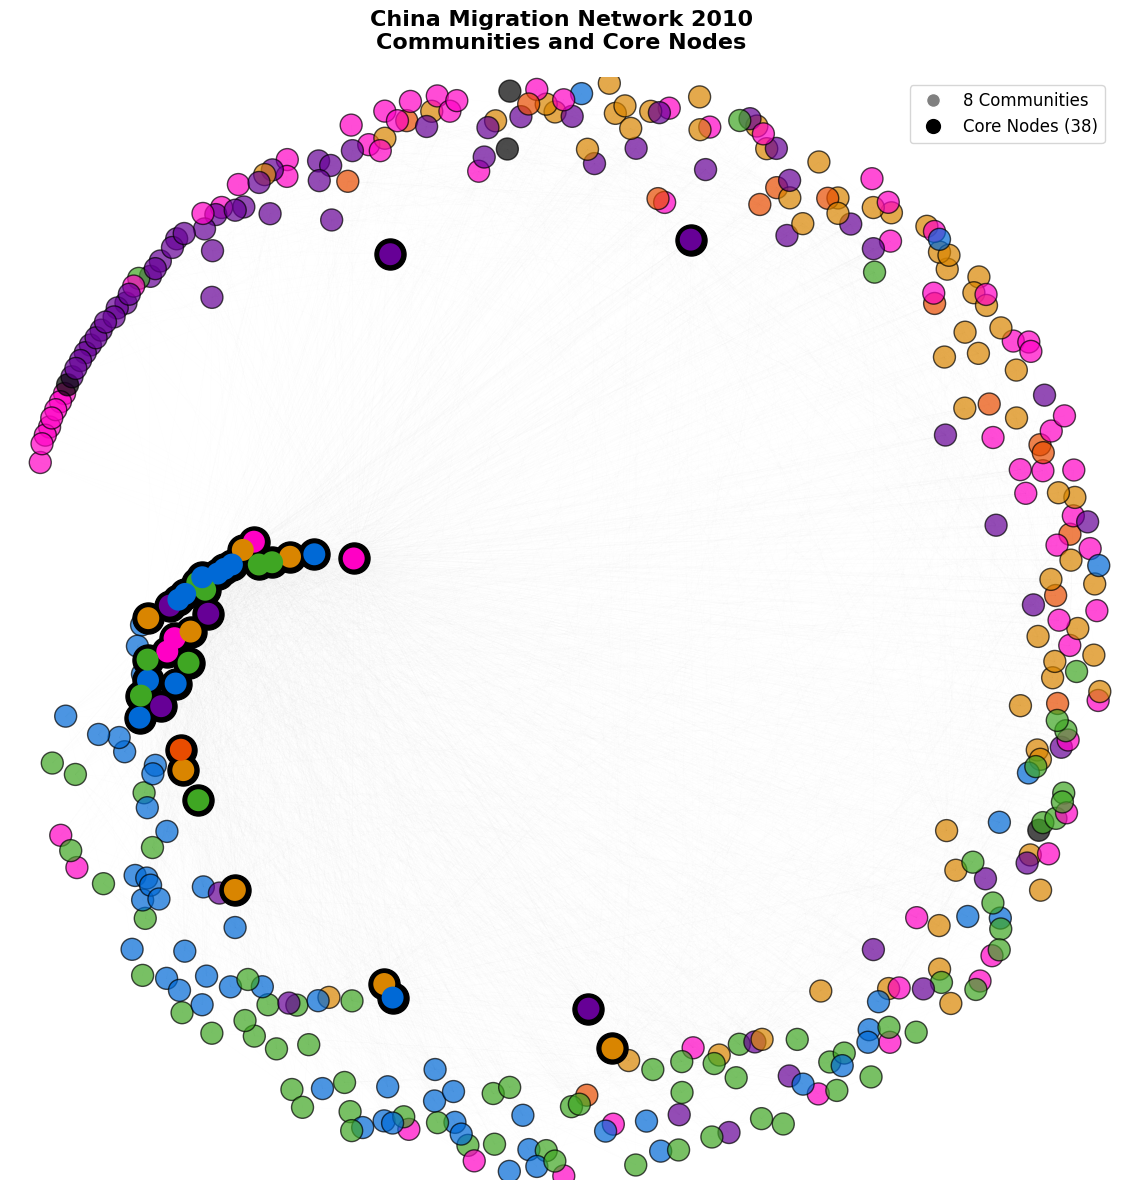


  3. Geographic map with TEU...
  Saved: hyperbolic_outputs\china_map_2010_teu.png


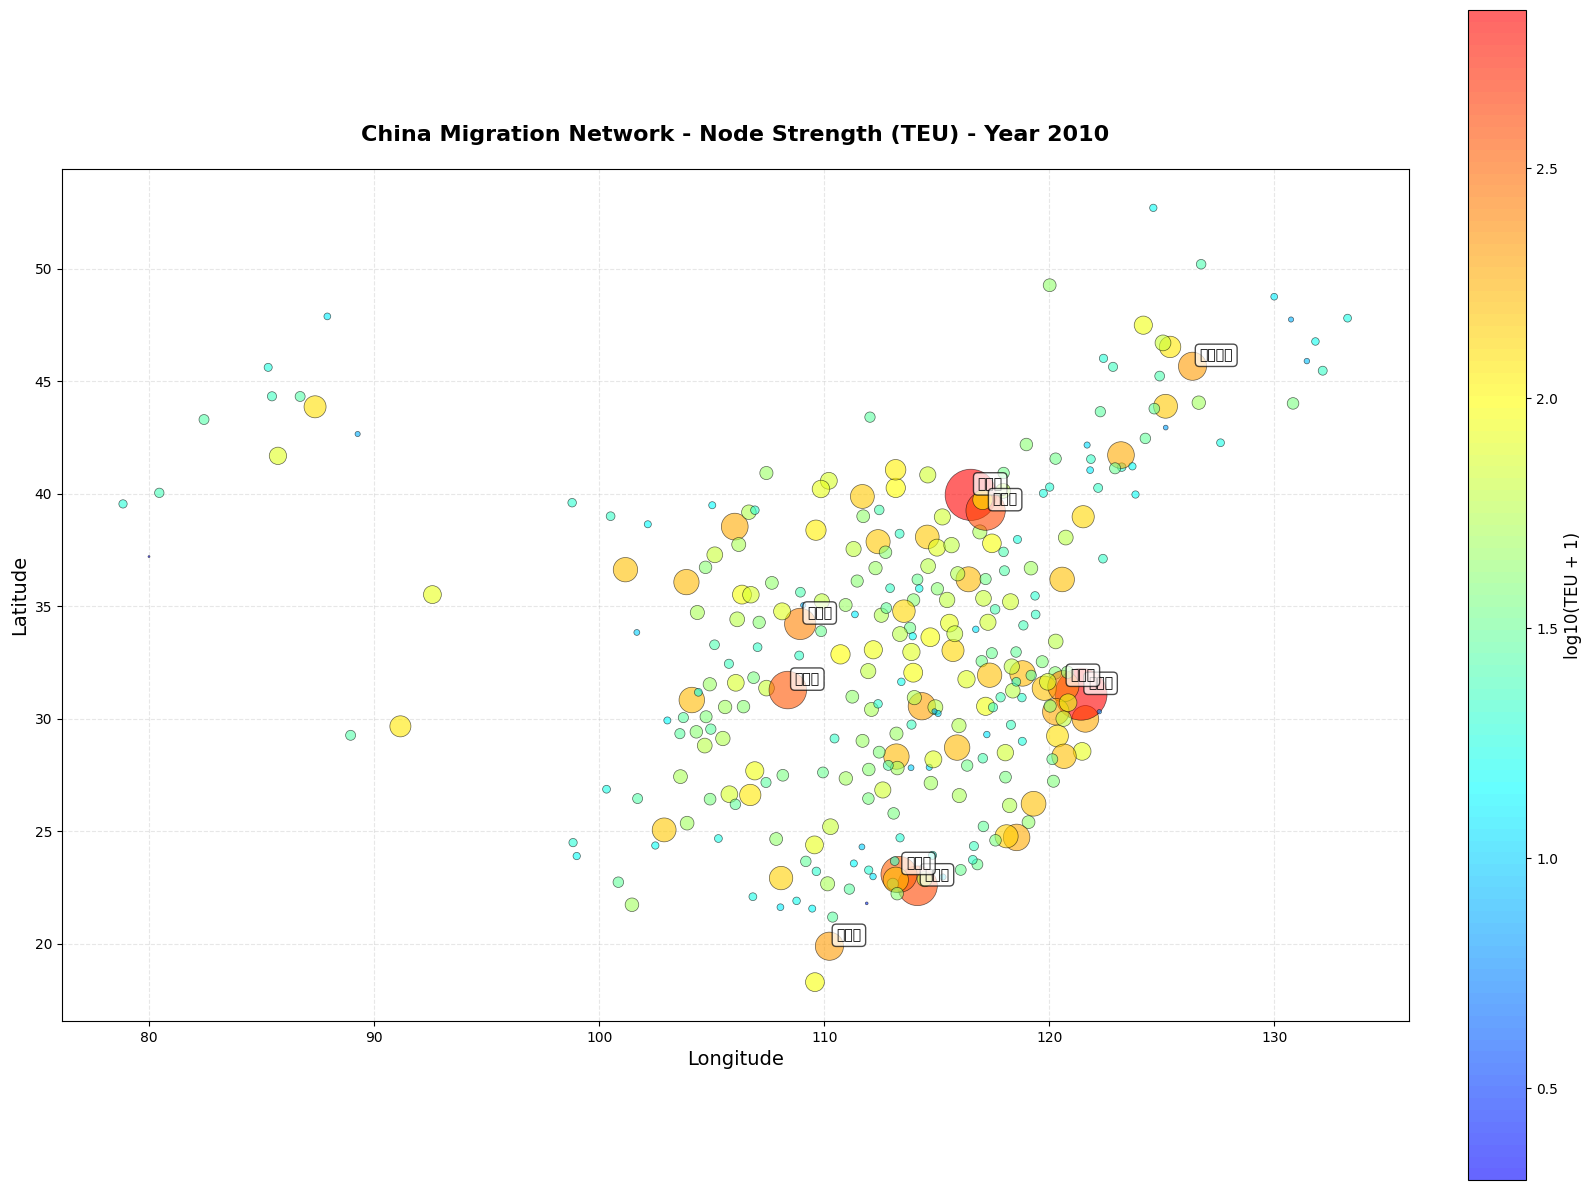


  ✓ Year 2010 complete!

Processing Year 2015
  Loaded network: (378, 378)
  Original graph has 378 nodes
  Mapped 297 cities to coordinates
  TEU computed: min=1, max=6086, mean=85

  Top 10 cities by TEU:
    1. nan: TEU=6086
    2. 北京市: TEU=864
    3. 上海市: TEU=771
    4. 深圳市: TEU=561
    5. 重庆市: TEU=527
    6. 广州市: TEU=526
    7. 天津市: TEU=465
    8. 成都市: TEU=358
    9. 苏州市: TEU=357
    10. 郑州市: TEU=335

  Unweighted undirected: 378 nodes, 4613 edges
  Starting MATLAB engine...
  Computing hyperbolic embedding...
  Embedding complete! Gamma=2.470
  Hyperbolic coords shape: (378, 2)
  Detecting communities...
  Found 9 communities
  Identified 38 core nodes (top 10% by degree)

  Creating visualizations...

  1. Hyperbolic embedding (MATLAB)...
  Starting MATLAB engine for plotting...
  Calling MATLAB plot_hyperbolic_network_v3...
  Saved: hyperbolic_outputs\china_network_2015_hyperbolic.png

  2. Communities and Core...
  Saved: hyperbolic_outputs\china_network_2015_communities.png


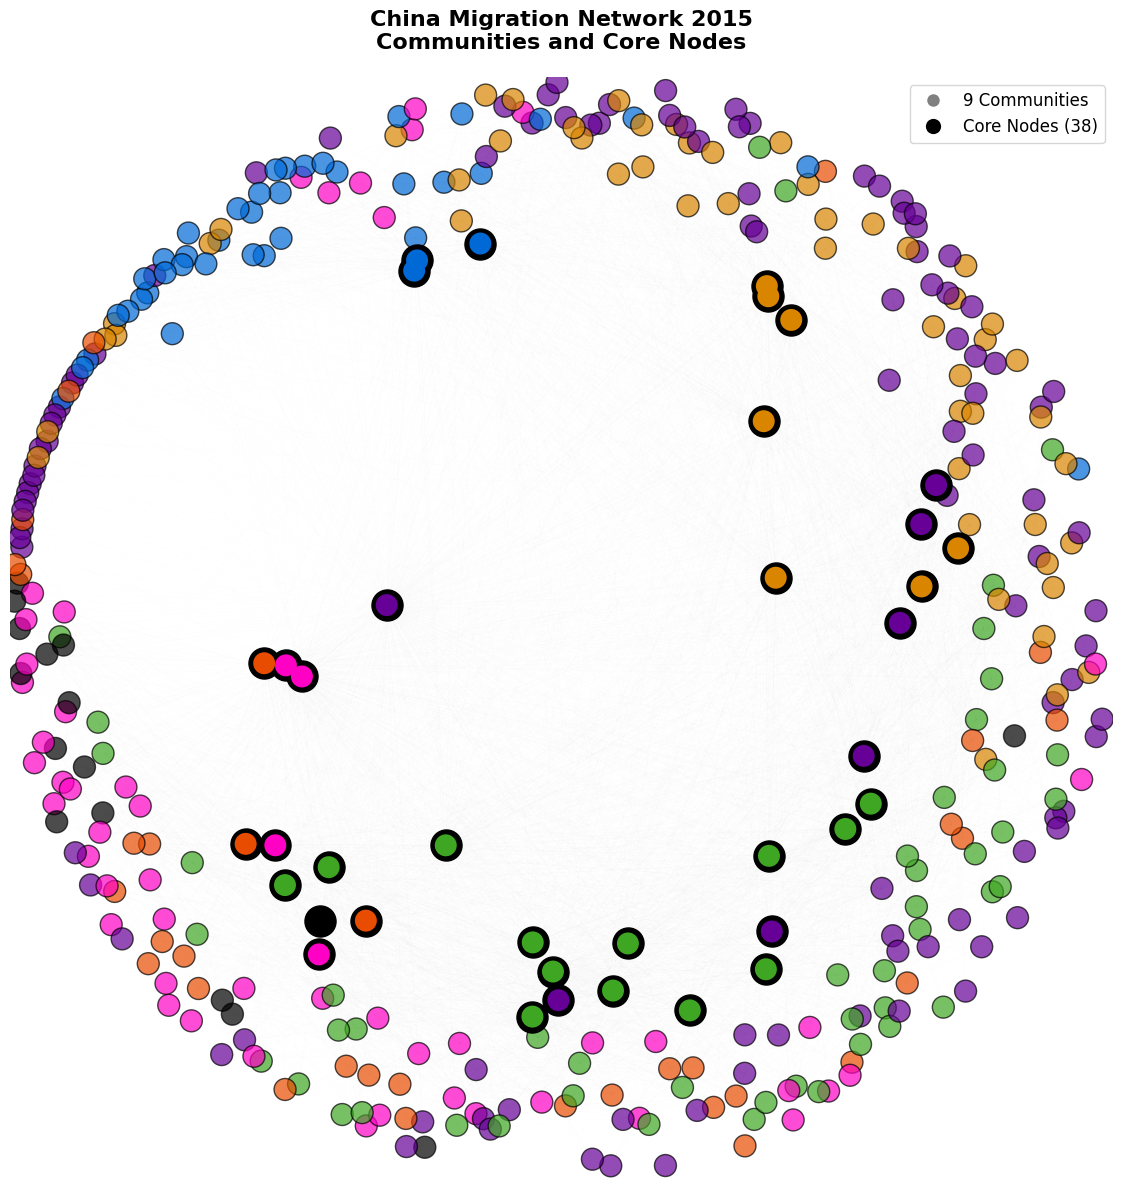


  3. Geographic map with TEU...
  Saved: hyperbolic_outputs\china_map_2015_teu.png


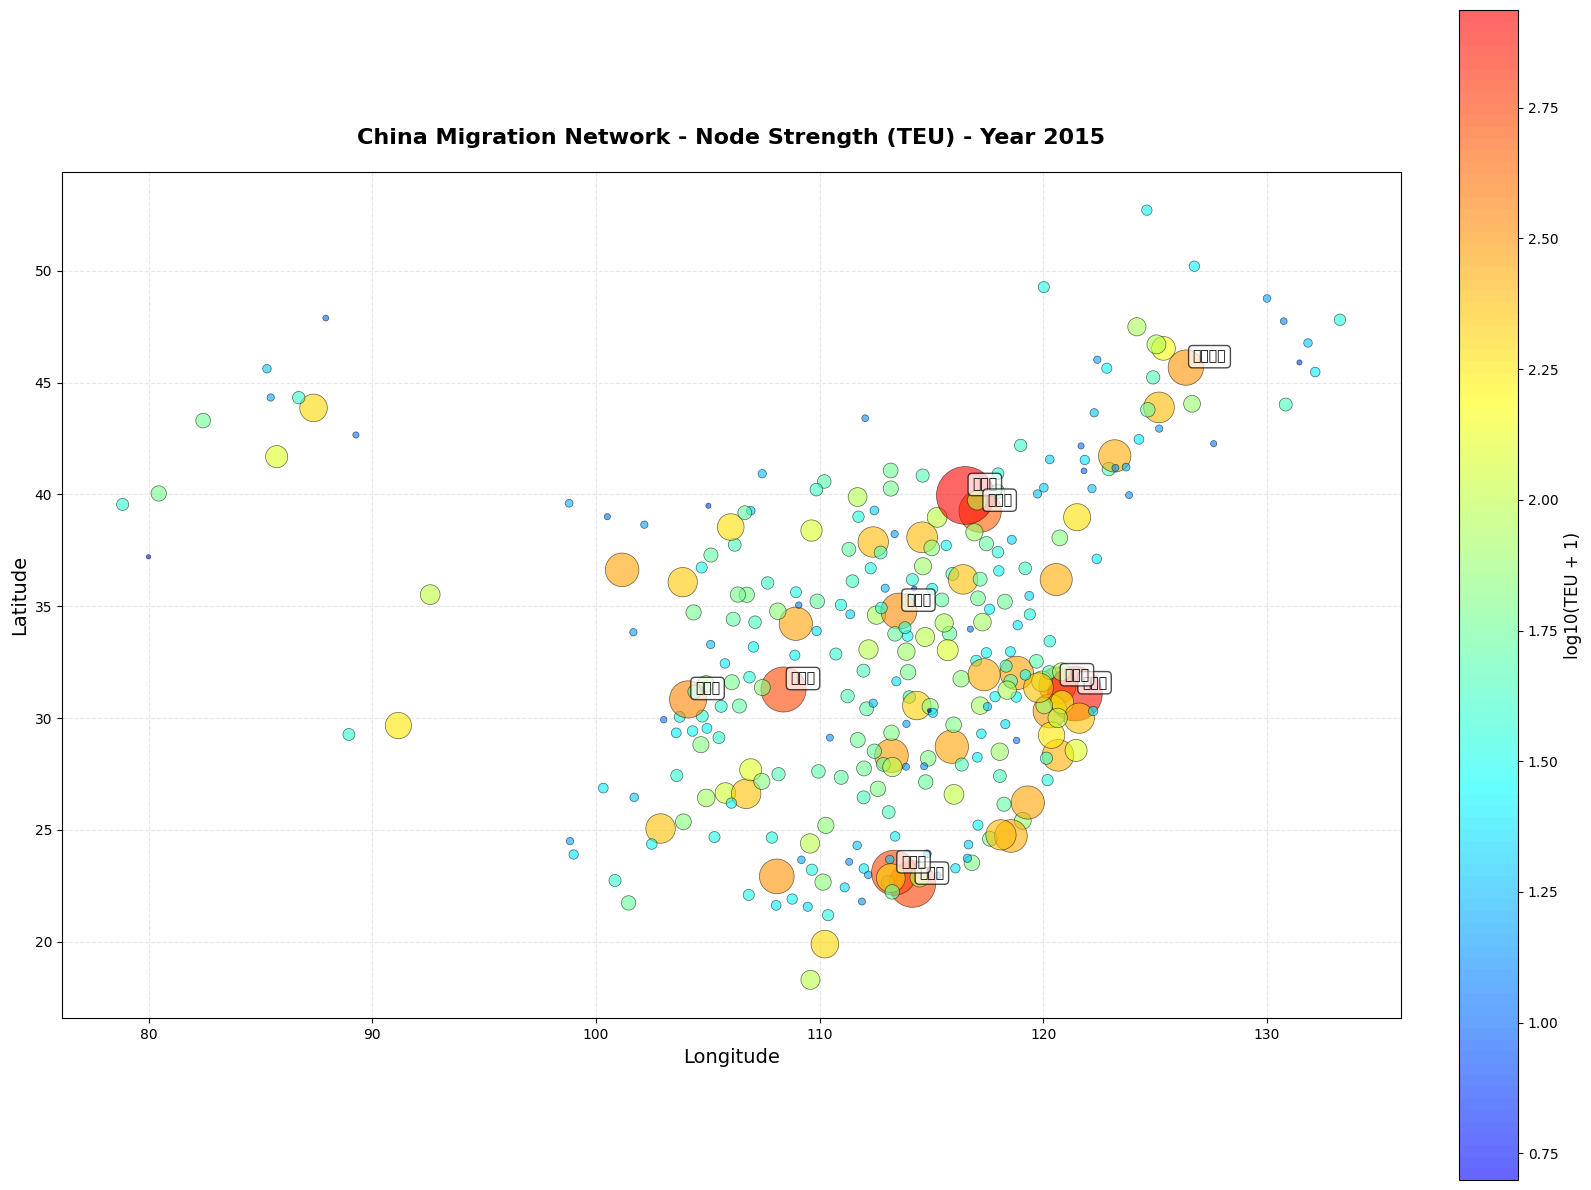


  ✓ Year 2015 complete!

Processing Year 2016
  Loaded network: (378, 378)
  Original graph has 378 nodes
  Mapped 297 cities to coordinates
  TEU computed: min=1, max=7707, mean=105

  Top 10 cities by TEU:
    1. nan: TEU=7707
    2. 上海市: TEU=1001
    3. 北京市: TEU=989
    4. 深圳市: TEU=828
    5. 广州市: TEU=671
    6. 重庆市: TEU=639
    7. 天津市: TEU=558
    8. 东莞市: TEU=479
    9. 南京市: TEU=460
    10. 苏州市: TEU=456

  Unweighted undirected: 378 nodes, 5107 edges
  Starting MATLAB engine...
  Computing hyperbolic embedding...
  Embedding complete! Gamma=2.510
  Hyperbolic coords shape: (378, 2)
  Detecting communities...
  Found 8 communities
  Identified 38 core nodes (top 10% by degree)

  Creating visualizations...

  1. Hyperbolic embedding (MATLAB)...
  Starting MATLAB engine for plotting...
  Calling MATLAB plot_hyperbolic_network_v3...
  Saved: hyperbolic_outputs\china_network_2016_hyperbolic.png

  2. Communities and Core...
  Saved: hyperbolic_outputs\china_network_2016_communities.pn

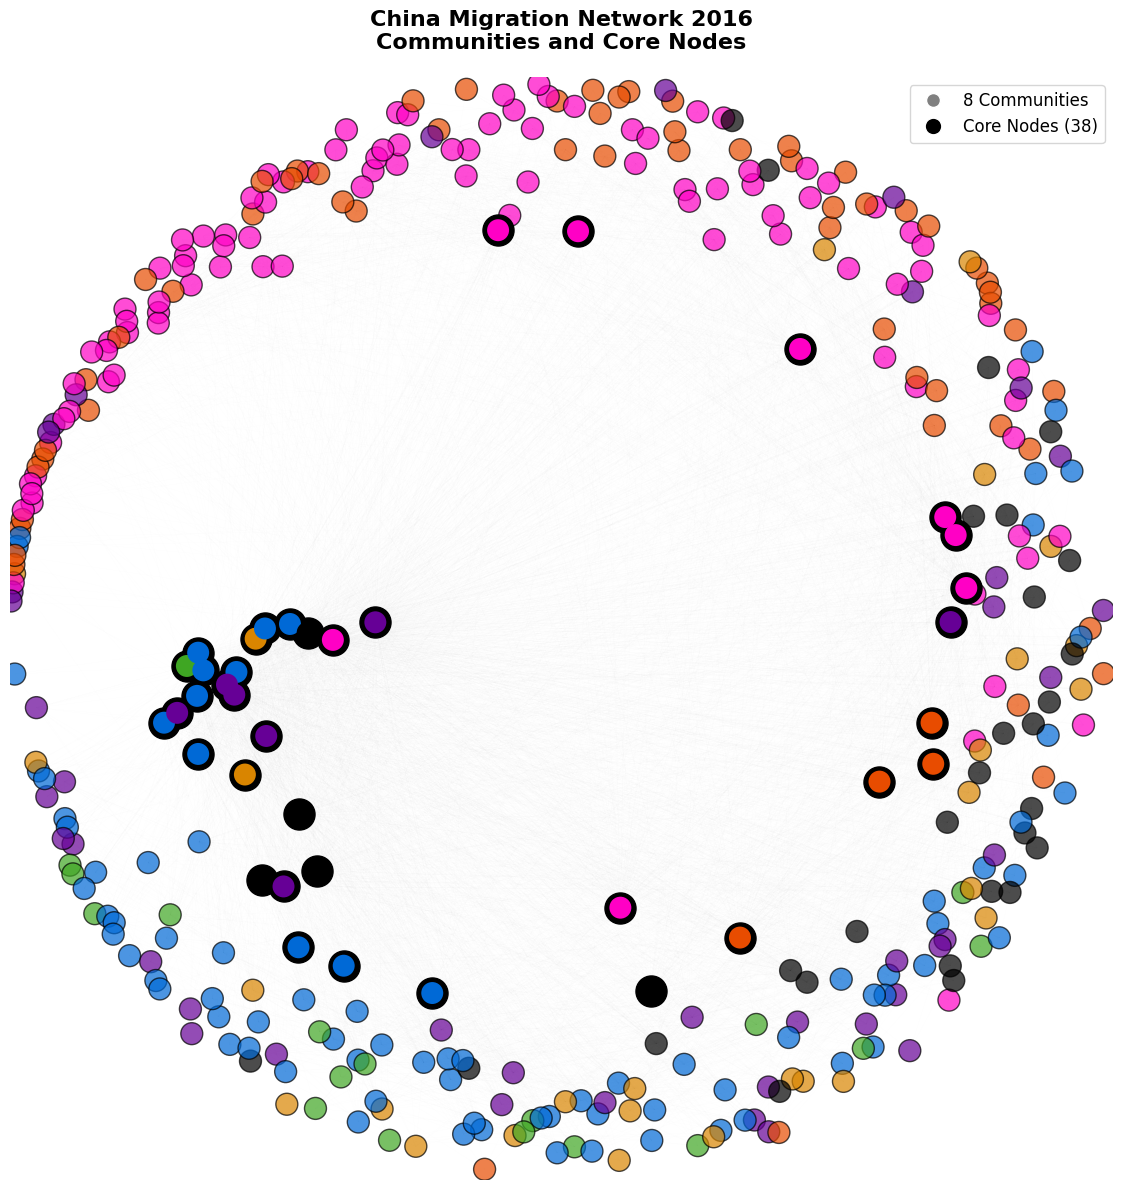


  3. Geographic map with TEU...
  Saved: hyperbolic_outputs\china_map_2016_teu.png


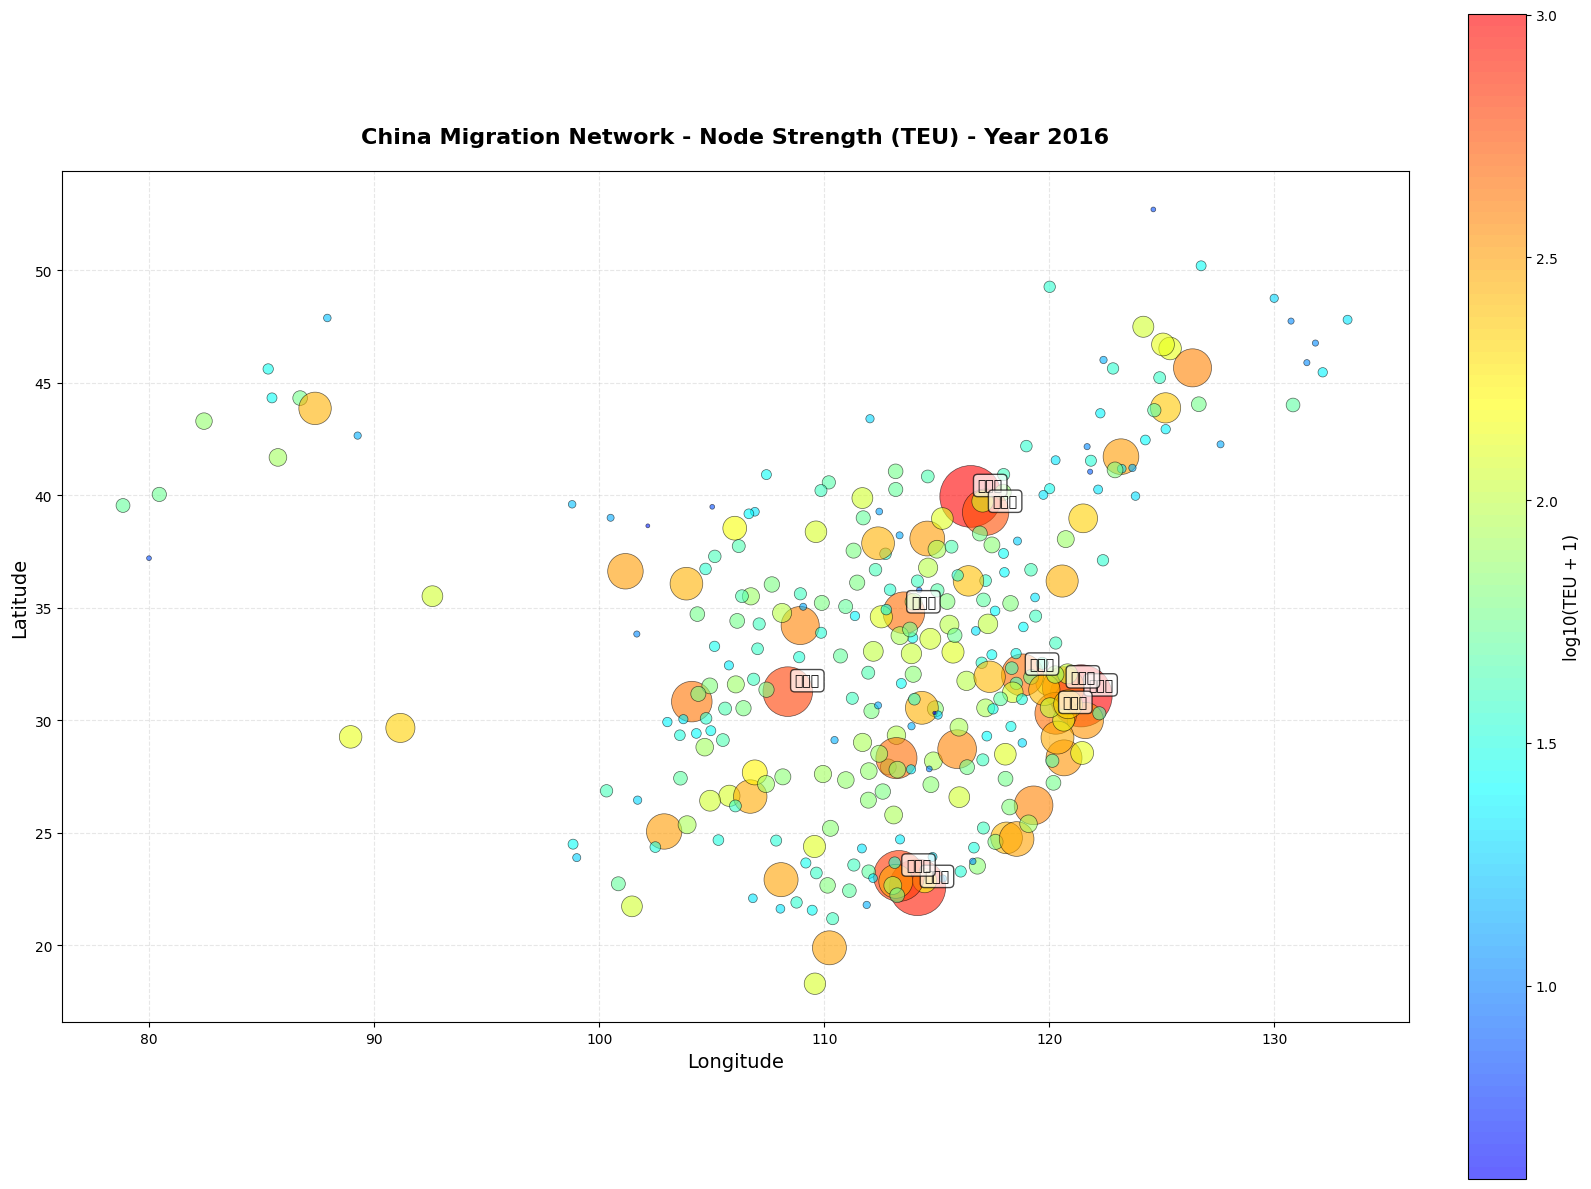


  ✓ Year 2016 complete!

All years processed!


In [25]:
# Store results for CSV export
all_results = []

for year in YEARS_TO_PROCESS:
    print(f"\n{'='*60}")
    print(f"Processing Year {year}")
    print(f"{'='*60}")
    
    # Load weighted directed network
    filepath = NETWORK_DATA_PATH / f'network_{year}_weighted_directed.npy'
    if not filepath.exists():
        print(f"  ⚠ File not found: {filepath}")
        continue
    
    adj_weighted_directed = np.load(filepath)
    print(f"  Loaded network: {adj_weighted_directed.shape}")
    
    # Build NetworkX graph to get city names for each node index
    G_original = build_migration_network_for_year(df, year)
    node_list = list(G_original.nodes())
    print(f"  Original graph has {len(node_list)} nodes")
    
    # Create mapping: node_index -> city_name
    node_to_city = {i: city for i, city in enumerate(node_list)}
    
    # Create city coordinate dataframe for this year's nodes
    city_coords_year = []
    for i, city_name in node_to_city.items():
        city_info = city_mapping[city_mapping['city_name'] == city_name]
        if len(city_info) > 0:
            city_coords_year.append({
                'node_id': i,
                'city_name': city_name,
                'lon': city_info.iloc[0]['lon'],
                'lat': city_info.iloc[0]['lat']
            })
        else:
            # If no coordinates, use default
            city_coords_year.append({
                'node_id': i,
                'city_name': city_name,
                'lon': np.nan,
                'lat': np.nan
            })
    
    city_coords_df = pd.DataFrame(city_coords_year)
    print(f"  Mapped {len(city_coords_df.dropna())} cities to coordinates")
    
    # Compute TEU (node strength)
    teu = compute_teu(adj_weighted_directed)
    print(f"  TEU computed: min={teu.min():.0f}, max={teu.max():.0f}, mean={teu.mean():.0f}")
    
    # Show top 10 cities by TEU
    top_10_indices = np.argsort(teu)[-10:][::-1]
    print(f"\n  Top 10 cities by TEU:")
    for rank, idx in enumerate(top_10_indices, 1):
        city_name = node_to_city.get(idx, f"Node {idx}")
        print(f"    {rank}. {city_name}: TEU={teu[idx]:.0f}")
    
    # Convert to unweighted undirected for hyperbolic embedding
    adj_unweighted_directed = (adj_weighted_directed > 0).astype(int)
    adj_matrix = np.maximum(adj_unweighted_directed, adj_unweighted_directed.T)
    
    num_nodes = adj_matrix.shape[0]
    num_edges = np.count_nonzero(adj_matrix) // 2
    print(f"\n  Unweighted undirected: {num_nodes} nodes, {num_edges} edges")
    
    # Compute hyperbolic coordinates
    coords, gamma = compute_polar_coordinates(
        adj_matrix, 
        MATLAB_CE_PATH,
        **HYPERBOLIC_PARAMS
    )
    print(f"  Hyperbolic coords shape: {coords.shape}")
    
    # Build NetworkX graph for community detection (using numeric indices)
    G = nx.from_numpy_array(adj_weighted_directed, create_using=nx.DiGraph)
    
    # Detect communities (on undirected version)
    print("  Detecting communities...")
    partition = detect_communities_louvain(G)
    n_communities = len(set(partition.values()))
    print(f"  Found {n_communities} communities")
    
    # Identify core nodes (returns list of node IDs, which are now 0 to n-1)
    core_nodes = identify_core_nodes(G, percentile=90)
    print(f"  Identified {len(core_nodes)} core nodes (top 10% by degree)")
    
    # Create visualizations
    print("\n  Creating visualizations...")
    
    # 1. Hyperbolic plot using MATLAB (Fig 1d style)
    print("\n  1. Hyperbolic embedding (MATLAB)...")
    matlab_filename = str(OUTPUT_DIR / f'china_network_{year}_hyperbolic')
    try:
        plot_hyperbolic_with_matlab(
            coords, adj_matrix, MATLAB_CE_PATH, matlab_filename
        )
    except Exception as e:
        print(f"    MATLAB plotting failed: {e}")
        print(f"    Falling back to Python plotting...")
        plot_figure_teu(
            adj_matrix, coords, teu, year,
            output_path=OUTPUT_DIR / f'china_network_{year}_teu.png'
        )
    
    # 2. Communities and Core (Python plot)
    print("\n  2. Communities and Core...")
    plot_figure_core_comm(
        adj_matrix, coords, partition, core_nodes, year,
        output_path=OUTPUT_DIR / f'china_network_{year}_communities.png'
    )
    
    # 3. Geographic map with TEU overlay
    print("\n  3. Geographic map with TEU...")
    city_coords_valid = city_coords_df.dropna()
    if len(city_coords_valid) > 0:
        # Align TEU values with city coordinates
        teu_for_map = np.array([teu[row['node_id']] for _, row in city_coords_valid.iterrows()])
        
        plot_teu_on_china_map(
            teu_for_map, 
            city_coords_valid,
            top_n=10,
            year=year,
            output_path=OUTPUT_DIR / f'china_map_{year}_teu.png'
        )
    else:
        print(f"    ⚠ No valid coordinates for geographic map")
    
    # Store results
    for i in range(num_nodes):
        city_name = node_to_city.get(i, f"Node {i}")
        city_coord = city_coords_df[city_coords_df['node_id'] == i]
        
        all_results.append({
            'year': year,
            'node_id': i,
            'city_name': city_name,
            'theta': coords[i, 0],
            'r': coords[i, 1],
            'x': coords[i, 1] * np.cos(coords[i, 0]),
            'y': coords[i, 1] * np.sin(coords[i, 0]),
            'teu': teu[i],
            'community': partition.get(i, -1),
            'is_core': i in core_nodes,
            'lon': city_coord.iloc[0]['lon'] if len(city_coord) > 0 else np.nan,
            'lat': city_coord.iloc[0]['lat'] if len(city_coord) > 0 else np.nan
        })
    
    print(f"\n  ✓ Year {year} complete!")

print(f"\n{'='*60}")
print("All years processed!")
print(f"{'='*60}")

## 7. Export Results for Map Plotting

In [26]:
# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Save to CSV
output_csv = OUTPUT_DIR / 'china_network_hyperbolic_data.csv'
results_df.to_csv(output_csv, index=False)

print(f"\n{'='*60}")
print("Results Summary")
print(f"{'='*60}")
print(f"Total records: {len(results_df)}")
print(f"Years: {sorted(results_df['year'].unique())}")
print(f"\nColumns in export:")
for col in results_df.columns:
    print(f"  - {col}")
print(f"\nSaved to: {output_csv}")
print(f"\nSample of data:")
display(results_df.head(10))


Results Summary
Total records: 1133
Years: [np.int64(2010), np.int64(2015), np.int64(2016)]

Columns in export:
  - year
  - node_id
  - city_name
  - theta
  - r
  - x
  - y
  - teu
  - community
  - is_core
  - lon
  - lat

Saved to: hyperbolic_outputs\china_network_hyperbolic_data.csv

Sample of data:


,year,node_id,city_name,theta,r,x,y,teu,community,is_core,lon,lat
0,2010,0,达州市,5.116546,9.727910,3.825442,-8.944172,64,6,False,107.432388,31.362205
1,2010,1,成都市,3.166592,8.326523,-8.323921,-0.208136,169,1,True,104.112993,30.832452
2,2010,2,北京市,2.883265,6.040836,-5.840393,1.543214,680,2,True,116.508837,39.951928
3,2010,3,眉山市,0.866646,10.932936,7.077833,8.332669,27,1,False,103.738033,30.051681
4,2010,4,昆明市,3.199925,8.494911,-8.480463,-0.495244,148,1,True,102.884172,25.060606
5,2010,5,淮南市,4.499894,10.868949,-2.292255,-10.624482,34,3,False,116.997513,32.559249
6,2010,6,合肥市,3.349921,9.276472,-9.075896,-1.918604,154,3,True,117.349156,31.936199
7,2010,7,济南市,4.866552,9.406147,1.444343,-9.294594,162,2,False,116.409116,36.197850
8,2010,8,NaN,2.816600,4.717207,-4.470276,1.506211,4889,1,True,NaN,NaN
9,2010,9,榆林市,1.049975,9.746589,4.849830,8.454298,107,0,False,109.631144,38.381641


## 8. Summary Statistics

In [27]:
# Summary by year
summary = results_df.groupby('year').agg({
    'node_id': 'count',
    'teu': ['min', 'max', 'mean', 'std'],
    'community': 'nunique',
    'is_core': 'sum'
}).round(2)

summary.columns = ['num_nodes', 'teu_min', 'teu_max', 'teu_mean', 'teu_std', 
                   'num_communities', 'num_core_nodes']

print("\nSummary by Year:")
print(summary)

# Save summary
summary.to_csv(OUTPUT_DIR / 'china_network_summary.csv')
print(f"\nSummary saved to: {OUTPUT_DIR / 'china_network_summary.csv'}")


Summary by Year:
      num_nodes  teu_min  teu_max  teu_mean  teu_std  num_communities  \
year                                                                    
2010        377        1     4889     67.40   259.75                8   
2015        378        1     6086     85.46   325.55                9   
2016        378        1     7707    105.38   412.80                8   

      num_core_nodes  
year                  
2010              38  
2015              38  
2016              38  

Summary saved to: hyperbolic_outputs\china_network_summary.csv


## 9. Visualize TEU Distribution

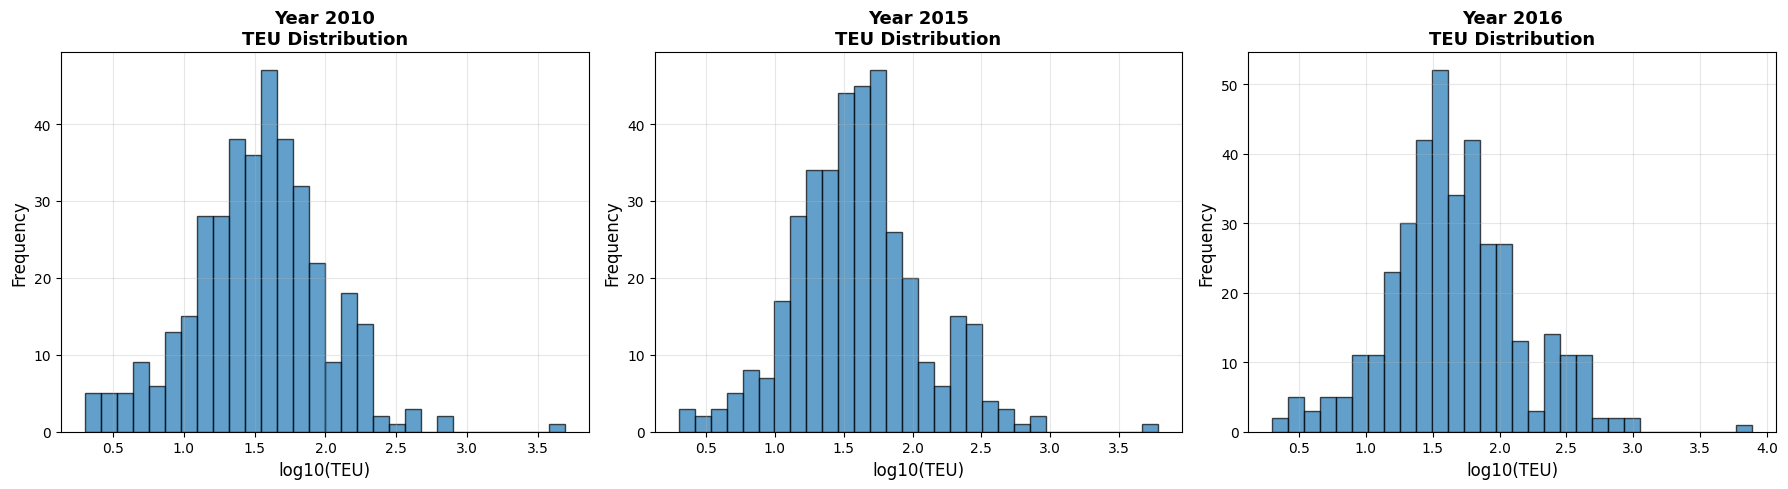

TEU distribution plot saved!


In [28]:
# Plot TEU distribution for each year
fig, axes = plt.subplots(1, len(YEARS_TO_PROCESS), figsize=(6*len(YEARS_TO_PROCESS), 5))
if len(YEARS_TO_PROCESS) == 1:
    axes = [axes]

for idx, year in enumerate(YEARS_TO_PROCESS):
    year_data = results_df[results_df['year'] == year]
    
    ax = axes[idx]
    ax.hist(np.log10(year_data['teu'] + 1), bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('log10(TEU)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Year {year}\nTEU Distribution', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'teu_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("TEU distribution plot saved!")

## 10. Usage Notes

**Output files:**
1. `china_network_{year}_hyperbolic.png` - Hyperbolic network visualization using MATLAB (best quality)
2. `china_network_{year}_communities.png` - Network colored by community with core highlighted (Fig 7 style)
3. `china_map_{year}_teu.png` - Geographic map of China with cities colored by TEU (with top 10 labels)
4. `china_network_hyperbolic_data.csv` - All data including city names and coordinates for further analysis
5. `china_network_summary.csv` - Summary statistics by year

**CSV columns for map plotting:**
- `year`: Year of the network
- `node_id`: Node index
- `city_name`: City name
- `theta`, `r`: Polar coordinates in hyperbolic space
- `x`, `y`: Cartesian coordinates in hyperbolic space
- `teu`: Node strength (total migration flow)
- `community`: Community assignment
- `is_core`: Boolean indicating if node is in the core
- `lon`, `lat`: Geographic coordinates

**Three types of visualizations:**

1. **Hyperbolic Space (MATLAB)**: Network embedded in hyperbolic disk
   - Better quality than Python matplotlib
   - Shows network topology in 2D hyperbolic space
   - Preserves distance relationships

2. **Communities & Core**: Network colored by detected communities
   - Shows modular structure
   - Highlights core nodes (top 10% by degree)
   - Identifies regional migration patterns

3. **Geographic Map**: Cities plotted on China map
   - Colored by TEU (node strength)
   - Top 10 cities labeled automatically
   - Shows spatial distribution of migration flows

**Key findings printed:**
- Top 10 cities by TEU for each year
- Community structure statistics
- Core node identification